# ATP Tennis Data - Player Diff Stats


In our feature engineering notebooks, we created a dataset for match where we left categorical columns un-encoded. We will run this dataset through various classification models and see how the models perform. I suspect tree based models (especially ensemble models) will perform the best as our data is non-linear

NOTE: since we are not one hot encoding our categories.. this is probably an invalid test. We are purely just getting a quick baseline since this dataset is small


# Summary of Results

* Our best results came from Gradient Boosting with the results below. 
* Only Logistic Regression and Gradient Boosting performed better than our baseline
*  Decision Tree, KNN, and AdaBoost all did below our baseline

```
Model Score: 0.6843349088453747

ROC/AUC Score: 0.6843094896328699
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.68      7381
         Win       0.68      0.69      0.69      7429

    accuracy                           0.68     14810
   macro avg       0.68      0.68      0.68     14810
weighted avg       0.68      0.68      0.68     14810

```




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, RSTATE, N_JOBS, MAX_ITER, LABEL_COL
import util.model_util as mu
import logging
import importlib

logging.basicConfig(level=logging.INFO)
%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d %H:%m'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "raw"


# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
# if you want to manually run this in DEBUG mode, change default value to True
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    DESCRIPTION = f"{DESCRIPTION}-test"
    FEATURE_FILE = '../datasets/atp_matches_1985-2019_features_test-raw_diff-ohe-history-matchup-stats.csv'
    ModelWrapper.REPORT_FILE = '../reports/summary-test.csv'
else:
    FEATURE_FILE = '../datasets/atp_matches_1985-2019_features-raw_diff-ohe-history-matchup-stats.csv'




START_YEAR = 1998
END_YEAR = 2018


column_filters = ["util.model_util.BaseRawFilter"]

In [2]:
X_train, X_test, y_train, y_test = ModelWrapper.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR, column_filters = column_filters)
print(f'Final columns: {X_test.columns}')

INFO:util.model_util:loading ../datasets/atp_matches_1985-2019_features-raw_diff-ohe-history-matchup-stats.csv
INFO:util.model_util:Shape before filtering: (59239, 5459)
INFO:util.model_util:Adding filter: util.model_util.BaseRawFilter
INFO:util.model_util:Shape after filtering: (59239, 13)
INFO:util.model_util:Final Features shape: (59239, 13)


Final columns: Index(['draw_size', 'round_label', 'tourney_level_label', 'tourney_month',
       'tourney_year', 'p1_age', 'p1_ht', 'p1_rank', 'p1_seed', 'p2_age',
       'p2_ht', 'p2_rank', 'p2_seed'],
      dtype='object')


# Get our baseline

If we really don't know anything about tennis, then a reasonable way of predicting wins/losses would be by player rank. If we look at our dataset, the accuracy of using this method for prediction would be the baseline accuracy for our model:

If player 1 rank < player 2 rank, then label == 1 (win)
If player 2 rank < player 1 rank, then label == 0 (loss)
Sum these two numbers and divide by total samples would give us the baseline accuracy


In [3]:
tests = pd.concat([X_test, y_test], axis=1)
p1_wins = tests[(tests.p1_rank < tests.p2_rank) & (tests.p1_winner == 1)]
p2_losses = tests[(tests.p2_rank < tests.p1_rank) & (tests.p1_winner == 0)]
baseline_accuracy = (len(p1_wins) + len(p2_losses))/ len(tests)
print(f'Our baseline accuracy should be: {baseline_accuracy}')

Our baseline accuracy should be: 0.6565833896016205


# Run all Models

In [4]:
models = [
    LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
    KNeighborsClassifier(n_jobs = N_JOBS),
    DecisionTreeClassifier(random_state = RSTATE),
    RandomForestClassifier(random_state=RSTATE, verbose=1),
    GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
    AdaBoostClassifier(random_state=RSTATE),
]

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




Running LogisticRegression
[LibLinear]

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Model Score: 0.6542876434841324

ROC/AUC Score: 0.6542967049181969
              precision    recall  f1-score   support

        Loss       0.65      0.66      0.65      7381
         Win       0.66      0.65      0.65      7429

    accuracy                           0.65     14810
   macro avg       0.65      0.65      0.65     14810
weighted avg       0.65      0.65      0.65     14810

      Loss   Win
Loss  4850  2531
Win   2589  4840


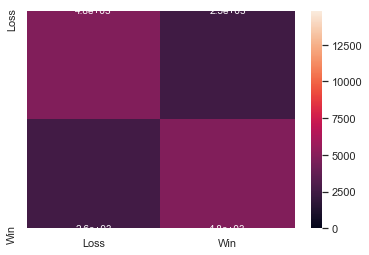

INFO:util.model_util:Saving model file: ../models/logisticregression-1998-2018-raw.pkl
INFO:util.model_util:Reading report: ../reports/summary.csv


Saving report: ../reports/summary.csv


Running KNeighborsClassifier
Model Score: 0.6105334233625929

ROC/AUC Score: 0.6105393990445503
              precision    recall  f1-score   support

        Loss       0.61      0.61      0.61      7381
         Win       0.61      0.61      0.61      7429

    accuracy                           0.61     14810
   macro avg       0.61      0.61      0.61     14810
weighted avg       0.61      0.61      0.61     14810

      Loss   Win
Loss  4520  2861
Win   2907  4522


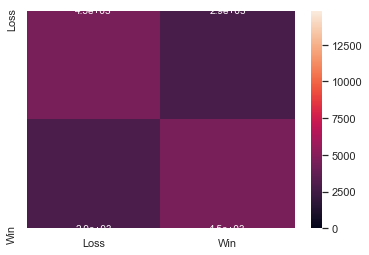

INFO:util.model_util:Saving model file: ../models/kneighborsclassifier-1998-2018-raw.pkl
INFO:util.model_util:Reading report: ../reports/summary.csv


Saving report: ../reports/summary.csv


Running DecisionTreeClassifier
Model Score: 0.5891289669142471

ROC/AUC Score: 0.5891121767664114
              precision    recall  f1-score   support

        Loss       0.59      0.58      0.59      7381
         Win       0.59      0.59      0.59      7429

    accuracy                           0.59     14810
   macro avg       0.59      0.59      0.59     14810
weighted avg       0.59      0.59      0.59     14810

      Loss   Win
Loss  4310  3071
Win   3014  4415


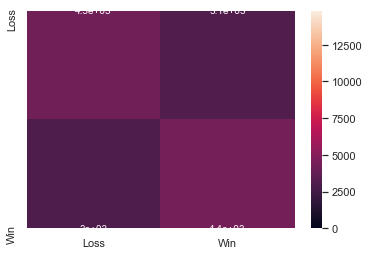

INFO:util.model_util:Saving model file: ../models/decisiontreeclassifier-1998-2018-raw.pkl
INFO:util.model_util:Reading report: ../reports/summary.csv


Saving report: ../reports/summary.csv


/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Running RandomForestClassifier
Model Score: 0.6447670492910196

ROC/AUC Score: 0.6449836941681344
              precision    recall  f1-score   support

        Loss       0.63      0.71      0.67      7381
         Win       0.67      0.58      0.62      7429

    accuracy                           0.64     14810
   macro avg       0.65      0.64      0.64     14810
weighted avg       0.65      0.64      0.64     14810

      Loss   Win
Loss  5254  2127
Win   3134  4295


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


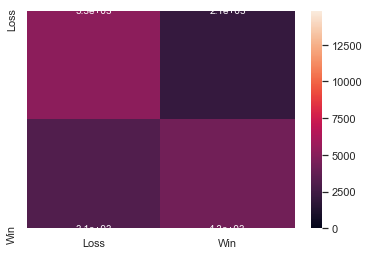

INFO:util.model_util:Saving model file: ../models/randomforestclassifier-1998-2018-raw.pkl
INFO:util.model_util:Reading report: ../reports/summary.csv


Saving report: ../reports/summary.csv


Running GradientBoostingClassifier
      Iter       Train Loss   Remaining Time 
         1           1.3670            3.18s
         2           1.3505            2.92s
         3           1.3357            2.80s
         4           1.3238            2.67s
         5           1.3131            2.62s
         6           1.3044            2.55s
         7           1.2958            2.50s
         8           1.2890            2.46s
         9           1.2825            2.61s
        10           1.2771            2.54s
        20           1.2394            2.04s
        30           1.2055            1.71s
        40           1.1861            1.42s
        50           1.1753            1.18s
        60           1.1667            0.93s
        70           1.1591            0.69s
        80           1.1540            0.45s
        90           1.1488            0.22s
       100           1.1460            0.00s
Model Score: 0.684334908

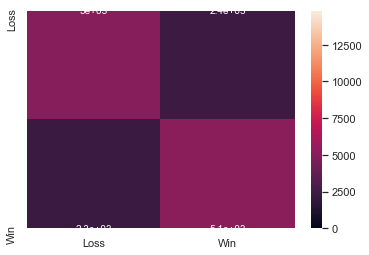

INFO:util.model_util:Saving model file: ../models/gradientboostingclassifier-1998-2018-raw.pkl
INFO:util.model_util:Reading report: ../reports/summary.csv


Saving report: ../reports/summary.csv


Running AdaBoostClassifier
Model Score: 0.6652937204591493

ROC/AUC Score: 0.6652575966906623
              precision    recall  f1-score   support

        Loss       0.67      0.65      0.66      7381
         Win       0.66      0.68      0.67      7429

    accuracy                           0.67     14810
   macro avg       0.67      0.67      0.67     14810
weighted avg       0.67      0.67      0.67     14810

      Loss   Win
Loss  4828  2553
Win   2404  5025


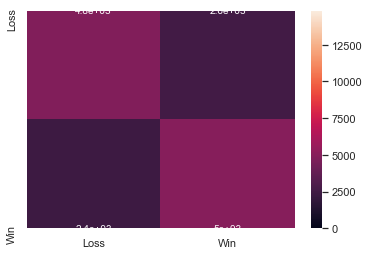

INFO:util.model_util:Saving model file: ../models/adaboostclassifier-1998-2018-raw.pkl
INFO:util.model_util:Reading report: ../reports/summary.csv


Saving report: ../reports/summary.csv


In [5]:
for model in models:
    print(f'\n\nRunning {type(model).__name__}')
    mw = mu.ModelWrapper(model,
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                    column_filters = column_filters)
    mw.fit(X_train, y_train)
    predict = mw.predict(X_test)
    mw.analyze(y_test)
    plt.show()
    mw.save()

# Summary

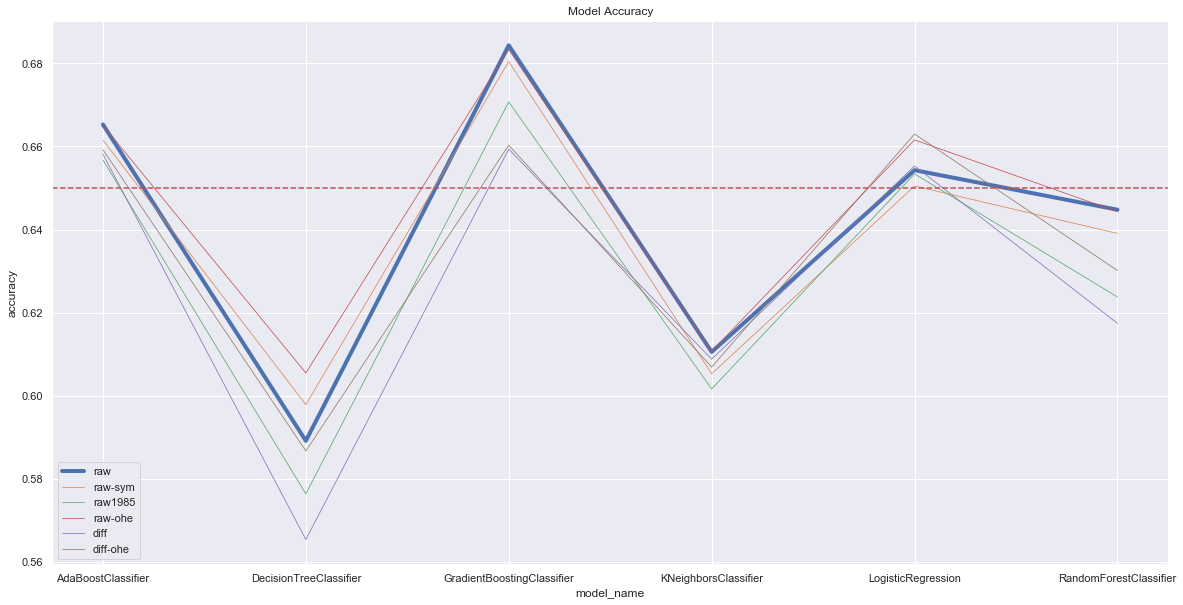

In [6]:
report = pd.read_csv(ModelWrapper.REPORT_FILE)

f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

Best Model: GradientBoostingClassifier


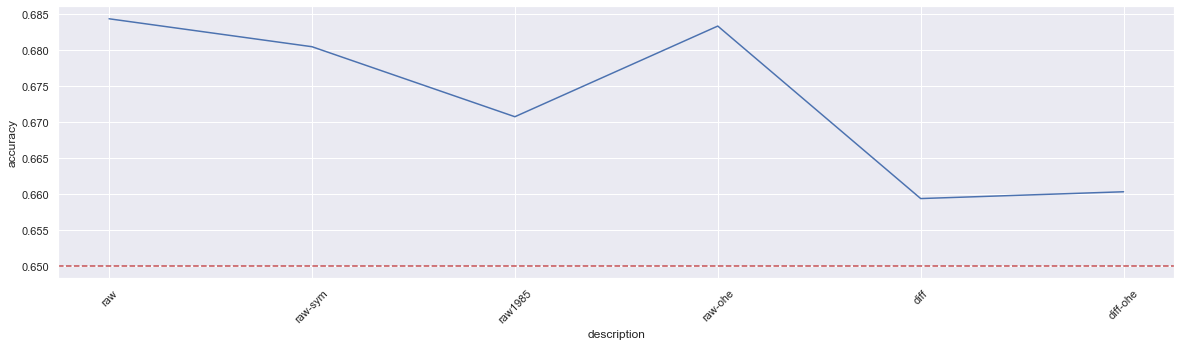

In [7]:
best_model = report.loc[report[report.description == DESCRIPTION].accuracy.idxmax()].model_name
print(f'Best Model: {best_model}')

dt_report = report[(report.model_name == 'GradientBoostingClassifier')]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.axhline(0.65, ls='--', color='r')
_ = a.set_label(f"{best_model} Accuracy")
_ = plt.xticks(rotation=45)


In [8]:
print(f'Last Finished: {datetime.now().strftime(DATE_FORMAT)}')

Last Finished: 2019-10-28 13:10
